# Capacitated Vehicle Routing Problem
This notebook shows how to use the PyVRP library to solve the Capacitated Vehicle Routing Problem (CVRP).

A CVRP instance is defined on a complete graph $G=(V,A)$, where $V$ is the vertex set and $A$ is the arc set. The vertex set $V$ is partitioned into $V=\{0\} \cup V_c$, where $0$ represents the depot and $V_c=\{1, \dots, n\}$ denotes the set of $n$ customers.
Each arc $(i, j) \in A$ has a weight $d_{ij} \ge 0$ that represents the travel distance from $i \in V$ to $j \in V$, which need not to be symmetric and/or euclidean.
Each customer $i \in V_c$ has a demand $q_{i} \ge 0$.
We assume that there is an unlimited number of homogeneous vehicles available, each with maximum capacity $Q > 0$.

A feasible solution to the CVRP consists of a set of routes that all begin and end at the depot, such that each customer is visited exactly once and none of the vehicles exceed their capacity. The objective is to find a feasible solution that minimizes the total distance.

In the following, we will configure the Hybrid Genetic Search algorithm to solve a single CVRP instance.

## Imports
First, we import some utilities and the solver components.

In [1]:
from typing import Optional
from pathlib import Path
from IPython.display import display

import matplotlib.pyplot as plt
import pandas as pd
import vrplib

from pyvrp import (
    GeneticAlgorithm,
    GeneticAlgorithmParams,
    Individual,
    PenaltyManager,
    Population,
    PopulationParams,
    ProblemData,
    XorShift128,
    diagnostics,
    plotting,
    read,
)
from pyvrp.crossover import selective_route_exchange as srex
from pyvrp.diversity import broken_pairs_distance as bpd
from pyvrp.educate import (
    NODE_OPERATORS,
    ROUTE_OPERATORS,
    LocalSearch,
    NeighbourhoodParams,
    compute_neighbours,
)
from pyvrp.stop import MaxIterations, MaxRuntime, StoppingCriterion

## Loading the instance
In this notebook we will solve the `X-n439-k37` instance, which is part of the [X instance set](http://vrp.atd-lab.inf.puc-rio.br/index.php/en/new-instances) that is widely used to benchmark CVRP algorithms. The function `pyvrp.read` reads the instance file and converts it to a `ProblemData` instance. We pass the argument `round_func='round'` to compute the Euclidean distances rounded to the nearest integral, which is the convention for the X benchmark set. We also load the best known solution to evaluate our solver later on.

In [2]:
instance = read("data/X-n439-k37.vrp", round_func="round")
instance_bks = vrplib.read_solution("data/X-n439-k37.sol")

By default, PyVRP is built to solve routing problems that include time windows. Since CVRP does not include time window data, the `pyvrp.read` uses placeholder values for customer time windows:

In [3]:
instance.client(1).tw_late

556652

This value is computed by taking the maximum route duration (number of clients $\times$ (maximum arc distance + maximum service time)). As a result, the time window constraints are always feasible and we can solve an instance of CVRP using a VRPTW solver.

## Plotting the instance

Let's plot the instance and see what we have. The function `plotting.plot_demands` will plot the demands of the instance: in this case, all customers have 1 demand. `plotting.plot_coordinates` plots the customer coordinates of the instance. 

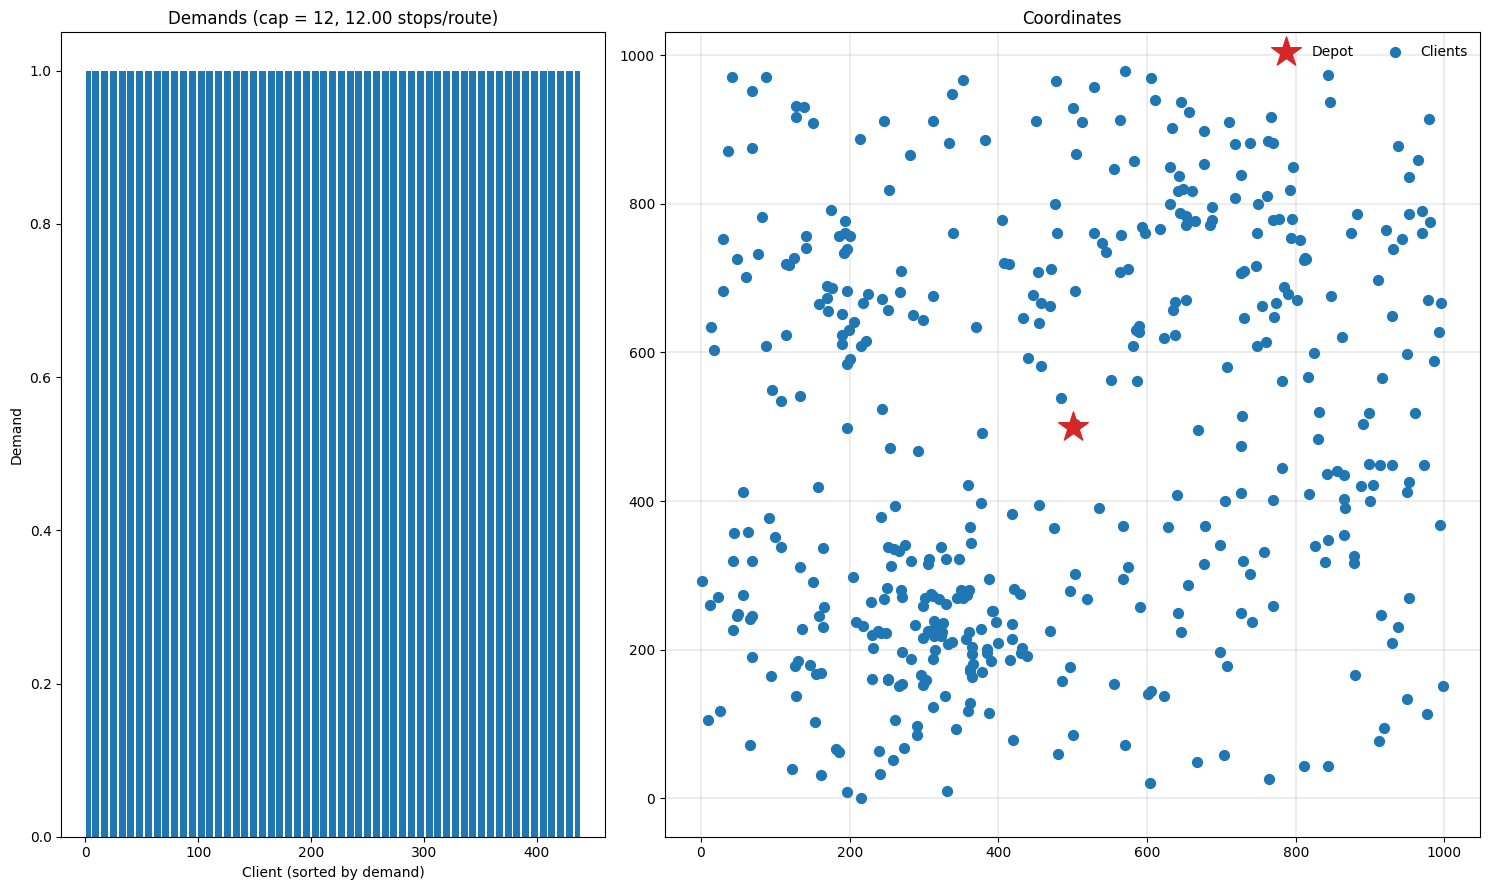

In [4]:
fig = plt.figure(figsize=(15, 9))
gs = fig.add_gridspec(2, 2, width_ratios=(2 / 5, 3 / 5))

plotting.plot_demands(instance, ax=fig.add_subplot(gs[:, 0]))
plotting.plot_coordinates(instance, ax=fig.add_subplot(gs[:, 1]))

plt.tight_layout()

## Configuring Hybrid Genetic Search
The next step is to implement a `solve` function that sets up the necessary components of the Hybrid Genetic Search. The components include `Population`, `LocalSearch`, and the `PenaltyManager`. Using these components, we can then initialise the `GeneticAlgorithm` object and run it until our desired `StoppingCriterion` is met. 

In [5]:
def solve(
    data: ProblemData,
    seed: int,
    max_runtime: Optional[float] = None,
    max_iterations: Optional[int] = None,
    **kwargs,
):
    rng = XorShift128(seed=seed)
    pen_manager = PenaltyManager(data.vehicle_capacity)

    pop_params = PopulationParams()
    pop = Population(bpd, params=pop_params)

    nb_params = NeighbourhoodParams(nb_granular=20)
    neighbours = compute_neighbours(data, params=nb_params)
    ls = LocalSearch(data, pen_manager, rng, neighbours)

    for op in NODE_OPERATORS:
        ls.add_node_operator(op(data, pen_manager))

    for op in ROUTE_OPERATORS:
        ls.add_route_operator(op(data, pen_manager))

    init = [
        Individual.make_random(data, pen_manager, rng)
        for _ in range(pop_params.min_pop_size)
    ]
    ga_params = GeneticAlgorithmParams(collect_statistics=True)
    algo = GeneticAlgorithm(
        data, pen_manager, rng, pop, ls, srex, init, params=ga_params
    )

    if max_runtime is not None:
        stop = MaxRuntime(max_runtime)
    else:
        assert max_iterations is not None
        stop = MaxIterations(max_iterations)

    return algo.run(stop)

## Solving the instance

Now let's run the algorithm using our `solve` function and compare the result with the best known solution.

In [6]:
def report_gap(result, bks):
    objective = result.best.cost()
    bks_cost = bks["cost"]
    pct_diff = 100 * (objective - bks_cost) / bks_cost

    print(f"Found a solution with cost: {objective}.")
    print(f"This is {pct_diff:.1f}% worse than the best known", end=" ")
    print(f"solution, which is {bks_cost}.")


result = solve(instance, seed=42, max_runtime=30)
report_gap(result, instance_bks)

Found a solution with cost: 36481.
This is 0.2% worse than the best known solution, which is 36391.


We've managed to find a near-optimal solution in 30 seconds! Let's plot the results.

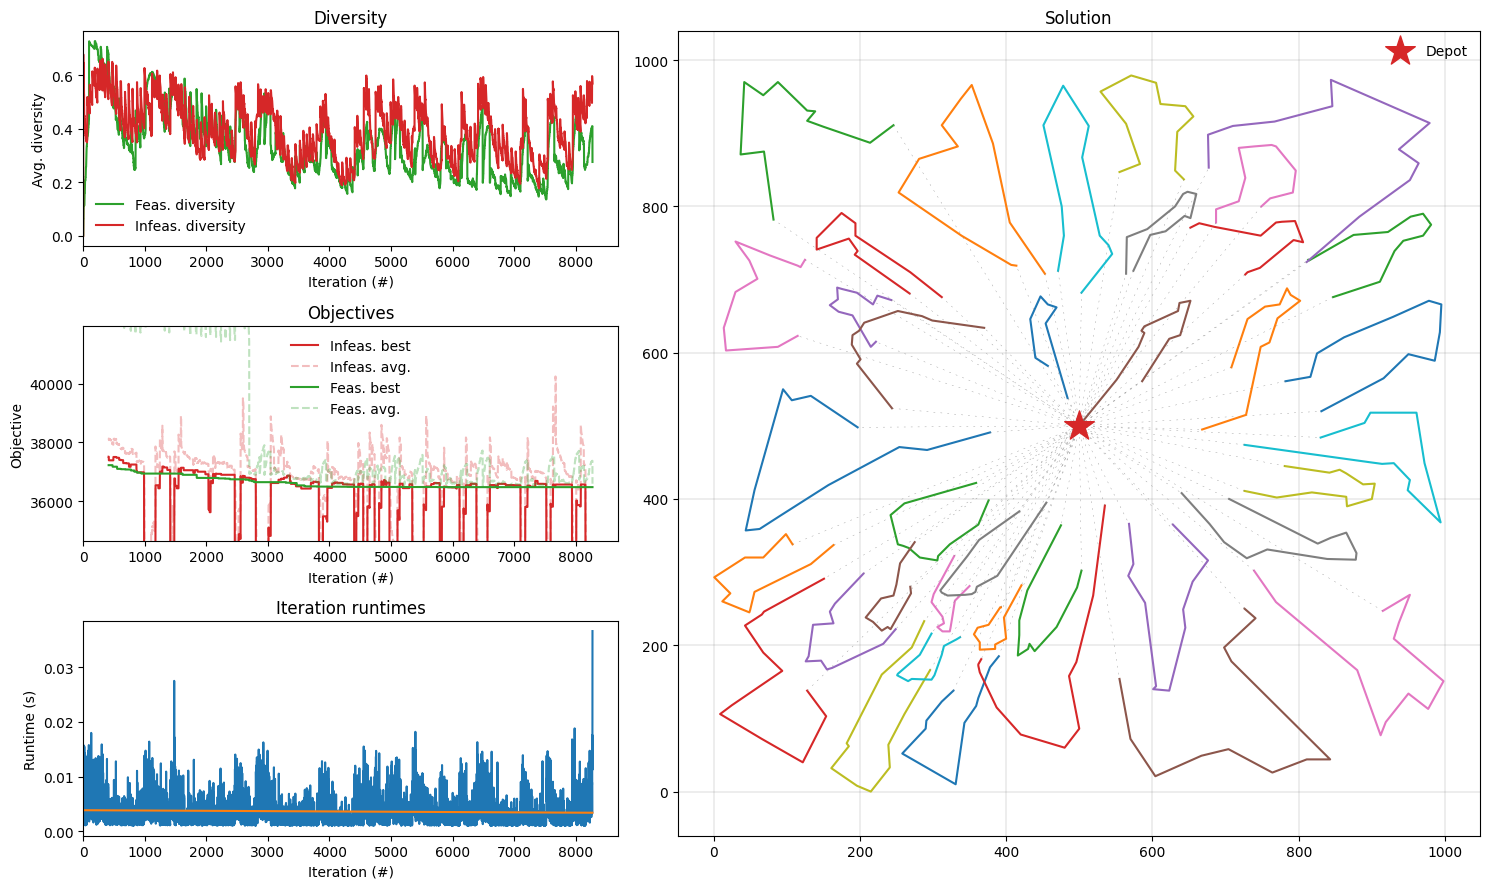

In [7]:
def plot_result(result, instance):
    fig = plt.figure(figsize=(15, 9))
    plotting.plot_result(result, instance, fig)
    fig.tight_layout()


plot_result(result, instance)

## Conclusion
In this notebook, we implemented the Hybrid Genetic Search algorithm to solve a CVRP instance with 493 customers to near-optimality. Moreover, we demonstrated how to use the plotting tools to visualize the instance and statistics obtained throughout the search procedure.